In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/PLN_INR Historical Data.csv


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
plt.style.use('fivethirtyeight')
from IPython.display import display

In [3]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FastICA 
from sklearn.manifold import TSNE 

In [4]:
df = pd.read_csv('../input/PLN_INR Historical Data.csv', sep='\t', index_col=0, parse_dates=True, usecols=['Date','Price','Open','High','Low'])
display(df.head())

,Price,Open,High,Low
Date,,,,
2019-07-09,18.03,18.07,18.14,18.03
2019-07-08,18.07,18.07,18.17,18.04
2019-07-07,18.07,18.07,18.08,18.06
2019-07-05,18.07,18.22,18.28,18.03
2019-07-04,18.23,18.31,18.34,18.20


In [5]:
df = df.rename(columns={'Price':'Close'})

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6849 entries, 2019-07-09 to 1993-06-16
Data columns (total 4 columns):
Close    6849 non-null float64
Open     6849 non-null float64
High     6849 non-null float64
Low      6849 non-null float64
dtypes: float64(4)
memory usage: 267.5 KB


In [7]:
# Add additional features
df['date'] = df.index
df['dayofweek'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofyear'] = df['date'].dt.dayofyear
df['dayofmonth'] = df['date'].dt.day
df['weekofyear'] = df['date'].dt.weekofyear
df['avg_price'] = (df['Low'] + df['High'])/2
df['range']     = df['High'] - df['Low']
# df['ohlc_price'] = (df['Low'] + df['High'] + df['Open'] + df['Close'])/4
# df['oc_diff']    = df['Open'] - df['Close']
df.head()

,Close,Open,High,Low,date,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,avg_price,range
Date,,,,,,,,,,,,,,
2019-07-09,18.03,18.07,18.14,18.03,2019-07-09,1,3,7,2019,190,9,28,18.085,0.11
2019-07-08,18.07,18.07,18.17,18.04,2019-07-08,0,3,7,2019,189,8,28,18.105,0.13
2019-07-07,18.07,18.07,18.08,18.06,2019-07-07,6,3,7,2019,188,7,27,18.070,0.02
2019-07-05,18.07,18.22,18.28,18.03,2019-07-05,4,3,7,2019,186,5,27,18.155,0.25
2019-07-04,18.23,18.31,18.34,18.20,2019-07-04,3,3,7,2019,185,4,27,18.270,0.14


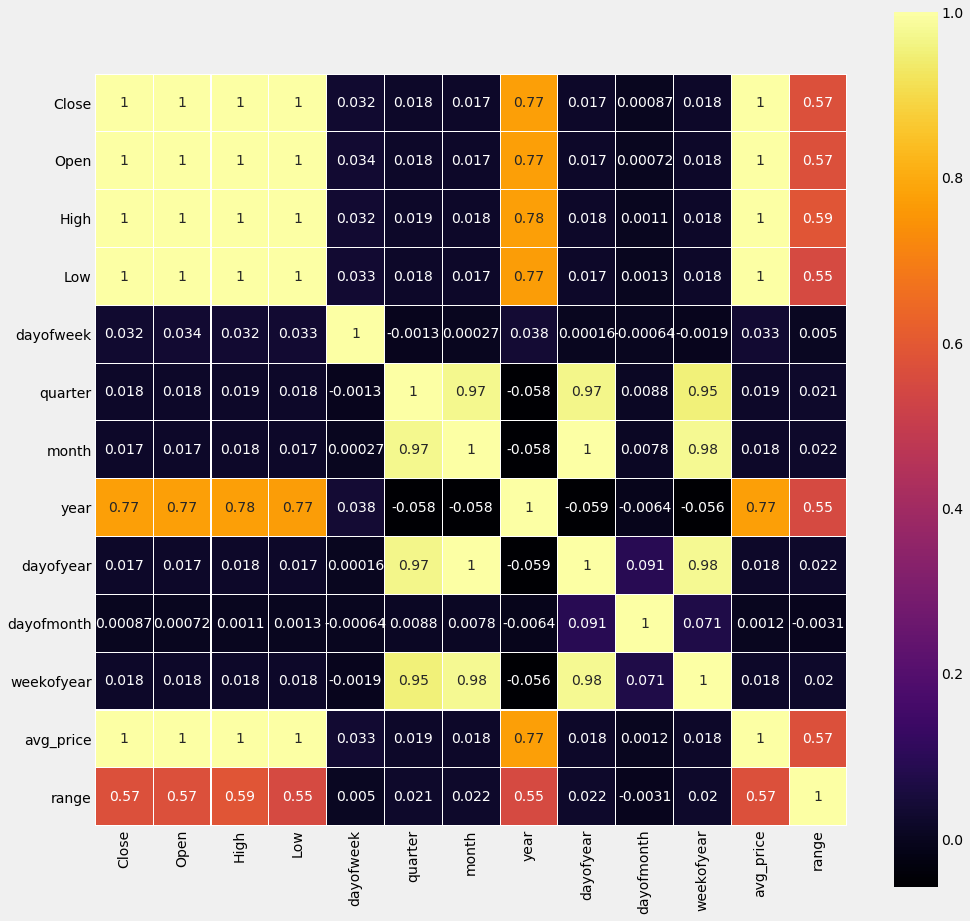

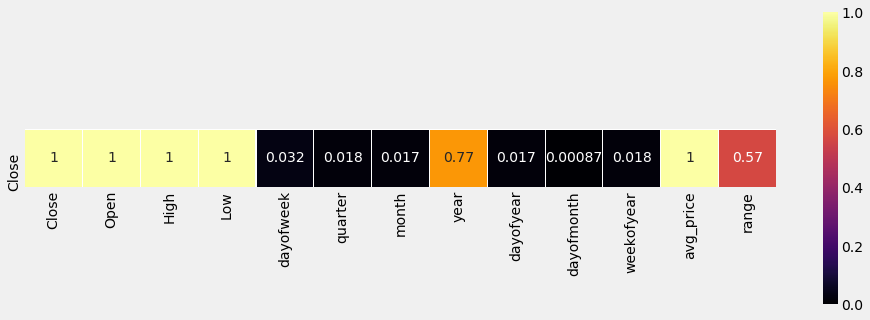

In [8]:
colormap = plt.cm.inferno
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

plt.figure(figsize=(15,5))
corr = df.corr()
sns.heatmap(corr[corr.index == 'Close'], linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True);

In [9]:
df.drop('date',1, inplace=True)
df.head(2)

,Close,Open,High,Low,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,avg_price,range
Date,,,,,,,,,,,,,
2019-07-09,18.03,18.07,18.14,18.03,1,3,7,2019,190,9,28,18.085,0.11
2019-07-08,18.07,18.07,18.17,18.04,0,3,7,2019,189,8,28,18.105,0.13


In [10]:
df.columns

Index(['Close', 'Open', 'High', 'Low', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear', 'avg_price', 'range'],
      dtype='object')

In [11]:
cols = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth','weekofyear']
df2 = df[cols]
df2.values

array([[  1,   3,   7, ..., 190,   9,  28],
       [  0,   3,   7, ..., 189,   8,  28],
       [  6,   3,   7, ..., 188,   7,  27],
       ...,
       [  0,   2,   6, ..., 172,  21,  25],
       [  4,   2,   6, ..., 169,  18,  24],
       [  2,   2,   6, ..., 167,  16,  24]])

In [12]:
from sklearn.preprocessing import OneHotEncoder
oneHC1 = OneHotEncoder()
df3 = oneHC1.fit_transform(df2.values)
df3 = pd.DataFrame(df3.toarray())

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [13]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,489,490,491,492,493,494,495,496,497,498
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
df = df.reset_index()

In [15]:
df.head()

,Date,Close,Open,High,Low,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,avg_price,range
0,2019-07-09,18.03,18.07,18.14,18.03,1,3,7,2019,190,9,28,18.085,0.11
1,2019-07-08,18.07,18.07,18.17,18.04,0,3,7,2019,189,8,28,18.105,0.13
2,2019-07-07,18.07,18.07,18.08,18.06,6,3,7,2019,188,7,27,18.070,0.02
3,2019-07-05,18.07,18.22,18.28,18.03,4,3,7,2019,186,5,27,18.155,0.25
4,2019-07-04,18.23,18.31,18.34,18.20,3,3,7,2019,185,4,27,18.270,0.14


In [16]:
df.values.shape, df3.values.shape

((6849, 14), (6849, 499))

In [17]:
df = pd.concat([df,df3],axis=1)


In [18]:
df = df.set_index('Date')
df.head()

,Close,Open,High,Low,dayofweek,quarter,month,year,dayofyear,dayofmonth,...,489,490,491,492,493,494,495,496,497,498
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-09,18.03,18.07,18.14,18.03,1,3,7,2019,190,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-08,18.07,18.07,18.17,18.04,0,3,7,2019,189,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-07,18.07,18.07,18.08,18.06,6,3,7,2019,188,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-05,18.07,18.22,18.28,18.03,4,3,7,2019,186,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-04,18.23,18.31,18.34,18.20,3,3,7,2019,185,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
from sklearn.ensemble import RandomForestRegressor
X = df.drop('Close',1)
y = df['Close'].values

scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

forest = RandomForestRegressor(n_estimators = 100)
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [20]:
forest.score(X_test, y_test), forest.score(X_train, y_train)

(0.999480923448699, 0.9999291750668331)

In [21]:
y_test[:10], forest.predict(X_test)[:10]

(array([12.68, 14.98, 15.8 , 14.94, 14.8 , 19.39, 15.7 , 18.47, 20.5 ,
        10.58]),
 array([12.6799, 14.8727, 15.7581, 14.9915, 14.8518, 19.3204, 15.5886,
        18.4589, 20.4749, 10.5817]))

In [22]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

[20:07:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

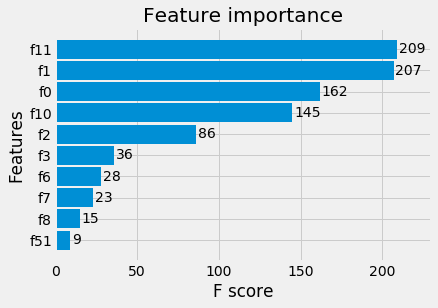

In [23]:
_ = plot_importance(reg, height=0.9,max_num_features=10 )

In [24]:
reg.score(X_test, y_test)

0.999395552520539

In [25]:
X_train.shape

(4794, 511)

In [26]:
def create_dataset(dataset, look_back=20):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [27]:
# Scale and create datasets
target_index = df.columns.tolist().index('Close')
high_index = df.columns.tolist().index('High')
low_index = df.columns.tolist().index('Low')
dataset = df.values.astype('float32')

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Create y_scaler to inverse it later
y_scaler = MinMaxScaler(feature_range=(0, 1))
t_y = df['Close'].values.astype('float32')
t_y = np.reshape(t_y, (-1, 1))
y_scaler = y_scaler.fit(t_y)
    
# Set look_back to 20 which is 5 hours (15min*20)
X, y = create_dataset(dataset, look_back=20)
y = y[:,target_index]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [29]:
X_train.shape

(4779, 20, 512)

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, CuDNNLSTM, Dense

# create a small LSTM network
model = Sequential()
model.add(CuDNNLSTM(20, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(CuDNNLSTM(20, return_sequences=True))
model.add(CuDNNLSTM(10, return_sequences=True))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(4, return_sequences=False))
model.add(Dense(4, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 20, 20)            42720     
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 20, 20)            3360      
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 20, 10)            1280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 10)            0         
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 4)                 256       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total para

In [31]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

# Fit
callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=200, batch_size=500, verbose=0, callbacks=callbacks_list, validation_split=0.1)


Epoch 00001: val_mean_squared_error improved from inf to 0.23156, saving model to weights.best.hdf5

Epoch 00002: val_mean_squared_error improved from 0.23156 to 0.22024, saving model to weights.best.hdf5

Epoch 00003: val_mean_squared_error improved from 0.22024 to 0.20651, saving model to weights.best.hdf5

Epoch 00004: val_mean_squared_error improved from 0.20651 to 0.18989, saving model to weights.best.hdf5

Epoch 00005: val_mean_squared_error improved from 0.18989 to 0.17099, saving model to weights.best.hdf5

Epoch 00006: val_mean_squared_error improved from 0.17099 to 0.15000, saving model to weights.best.hdf5

Epoch 00007: val_mean_squared_error improved from 0.15000 to 0.12782, saving model to weights.best.hdf5

Epoch 00008: val_mean_squared_error improved from 0.12782 to 0.10583, saving model to weights.best.hdf5

Epoch 00009: val_mean_squared_error improved from 0.10583 to 0.08569, saving model to weights.best.hdf5

Epoch 00010: val_mean_squared_error improved from 0.08569 

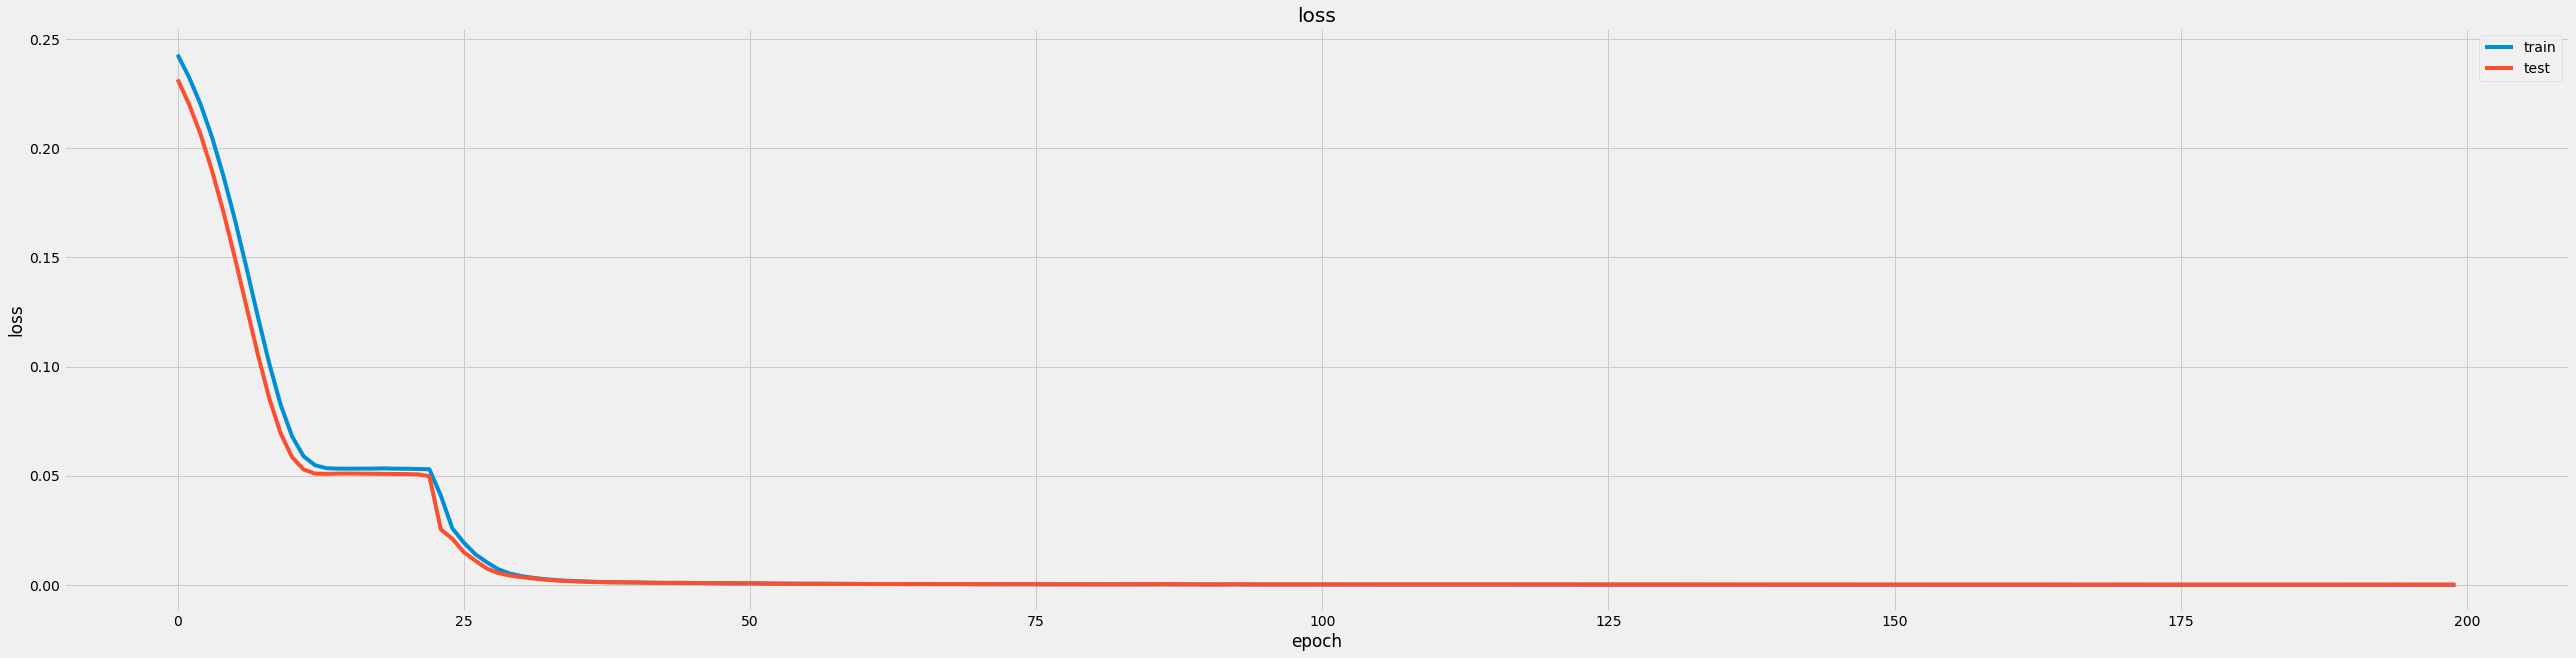

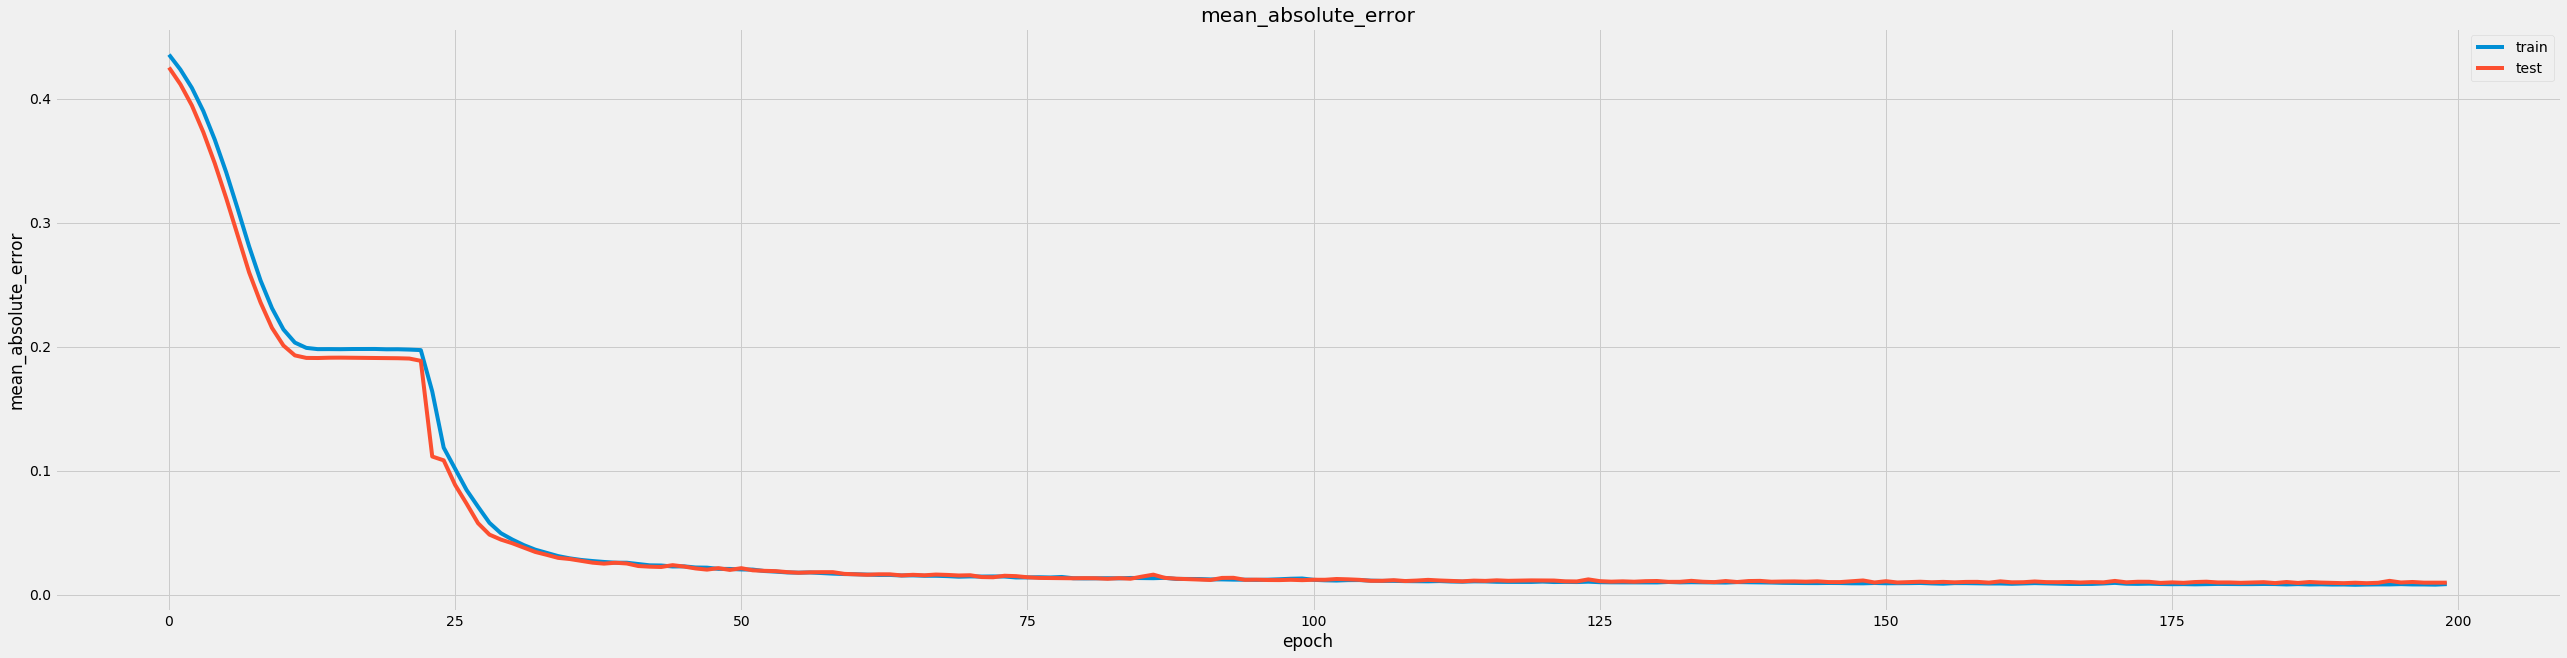

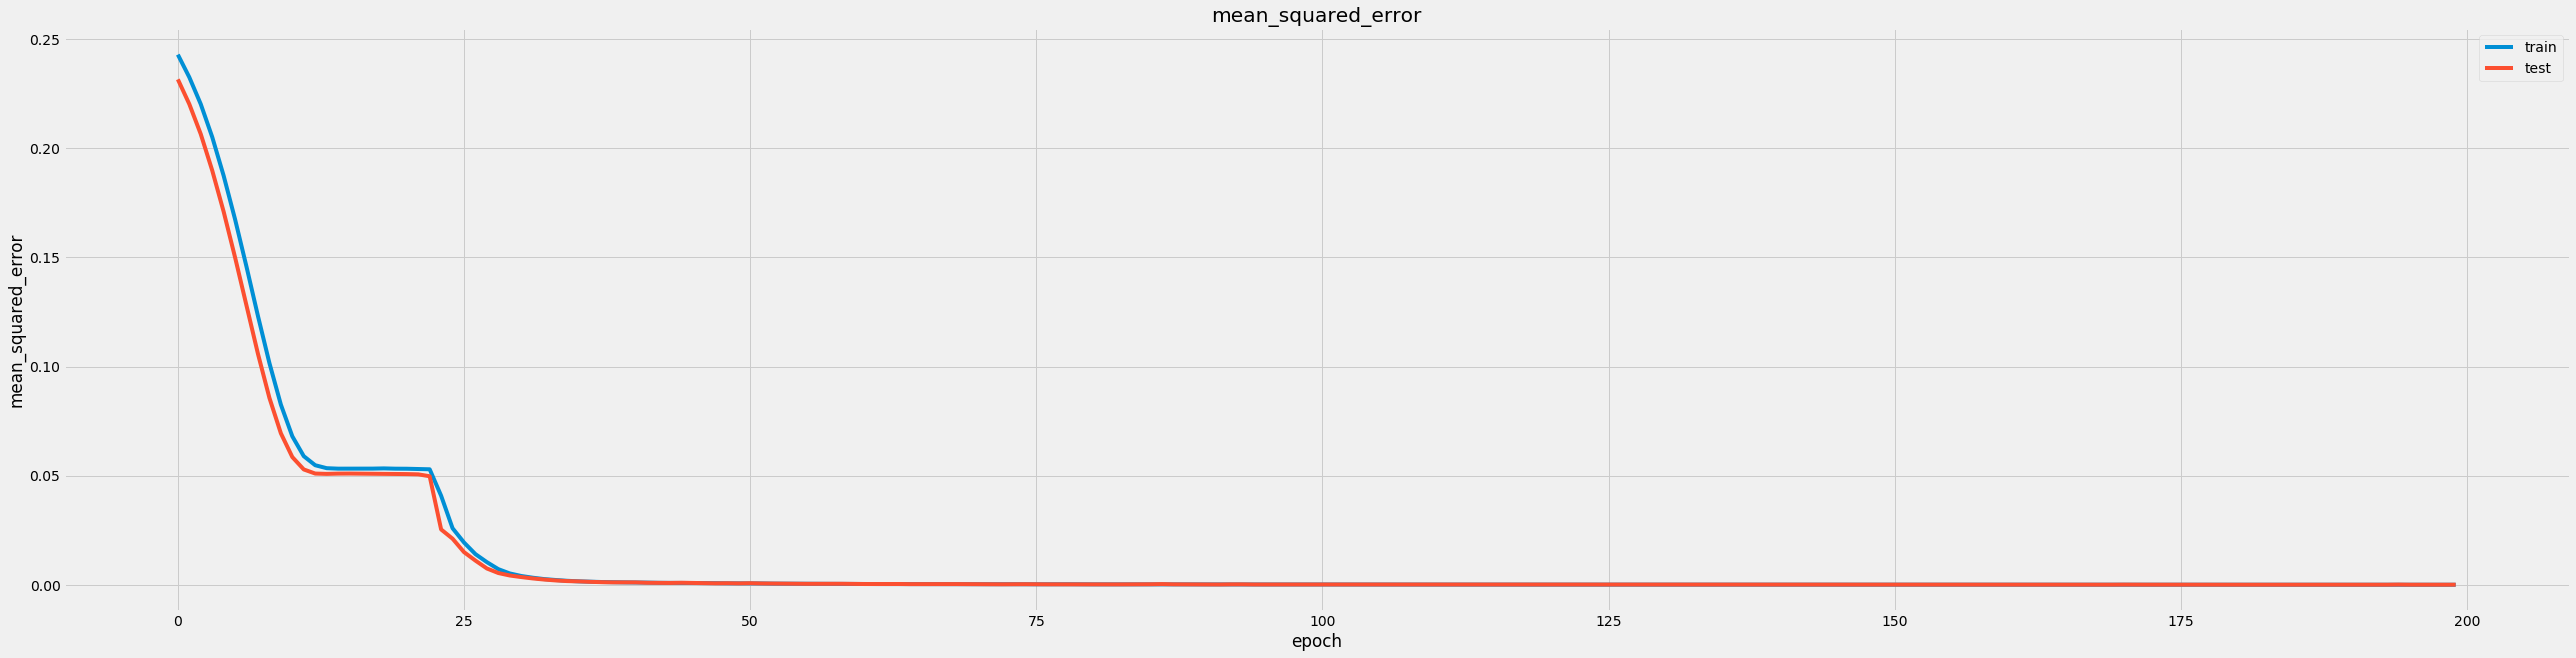

In [32]:
epoch = len(history.history['loss'])
for k in list(history.history.keys()):
    if 'val' not in k:
        plt.figure(figsize=(40,10))
        plt.plot(history.history[k])
        plt.plot(history.history['val_' + k])
        plt.title(k)
        plt.ylabel(k)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()

In [33]:
min(history.history['val_mean_absolute_error'])

0.009217414073646069

In [34]:
# Baby the model a bit
# Load the weight that worked the best
model.load_weights("weights.best.hdf5")

# Train again with decaying learning rate
from keras.callbacks import LearningRateScheduler
import keras.backend as K

def scheduler(epoch):
    if epoch%2==0 and epoch!=0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr*.9)
        print("lr changed to {}".format(lr*.9))
    return K.get_value(model.optimizer.lr)
lr_decay = LearningRateScheduler(scheduler)

callbacks_list = [checkpoint, lr_decay]
history = model.fit(X_train, y_train, epochs=int(epoch/3), batch_size=500, verbose=0, callbacks=callbacks_list, validation_split=0.1)


Epoch 00001: val_mean_squared_error did not improve from 0.00016

Epoch 00002: val_mean_squared_error did not improve from 0.00016
lr changed to 0.0009000000427477062

Epoch 00003: val_mean_squared_error did not improve from 0.00016

Epoch 00004: val_mean_squared_error did not improve from 0.00016
lr changed to 0.0008100000384729356

Epoch 00005: val_mean_squared_error did not improve from 0.00016

Epoch 00006: val_mean_squared_error did not improve from 0.00016
lr changed to 0.0007290000503417104

Epoch 00007: val_mean_squared_error did not improve from 0.00016

Epoch 00008: val_mean_squared_error did not improve from 0.00016
lr changed to 0.0006561000715009868

Epoch 00009: val_mean_squared_error did not improve from 0.00016

Epoch 00010: val_mean_squared_error did not improve from 0.00016
lr changed to 0.0005904900433961303

Epoch 00011: val_mean_squared_error did not improve from 0.00016

Epoch 00012: val_mean_squared_error improved from 0.00016 to 0.00015, saving model to weights

In [35]:
history.history.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'val_mean_squared_error', 'loss', 'mean_absolute_error', 'mean_squared_error', 'lr'])

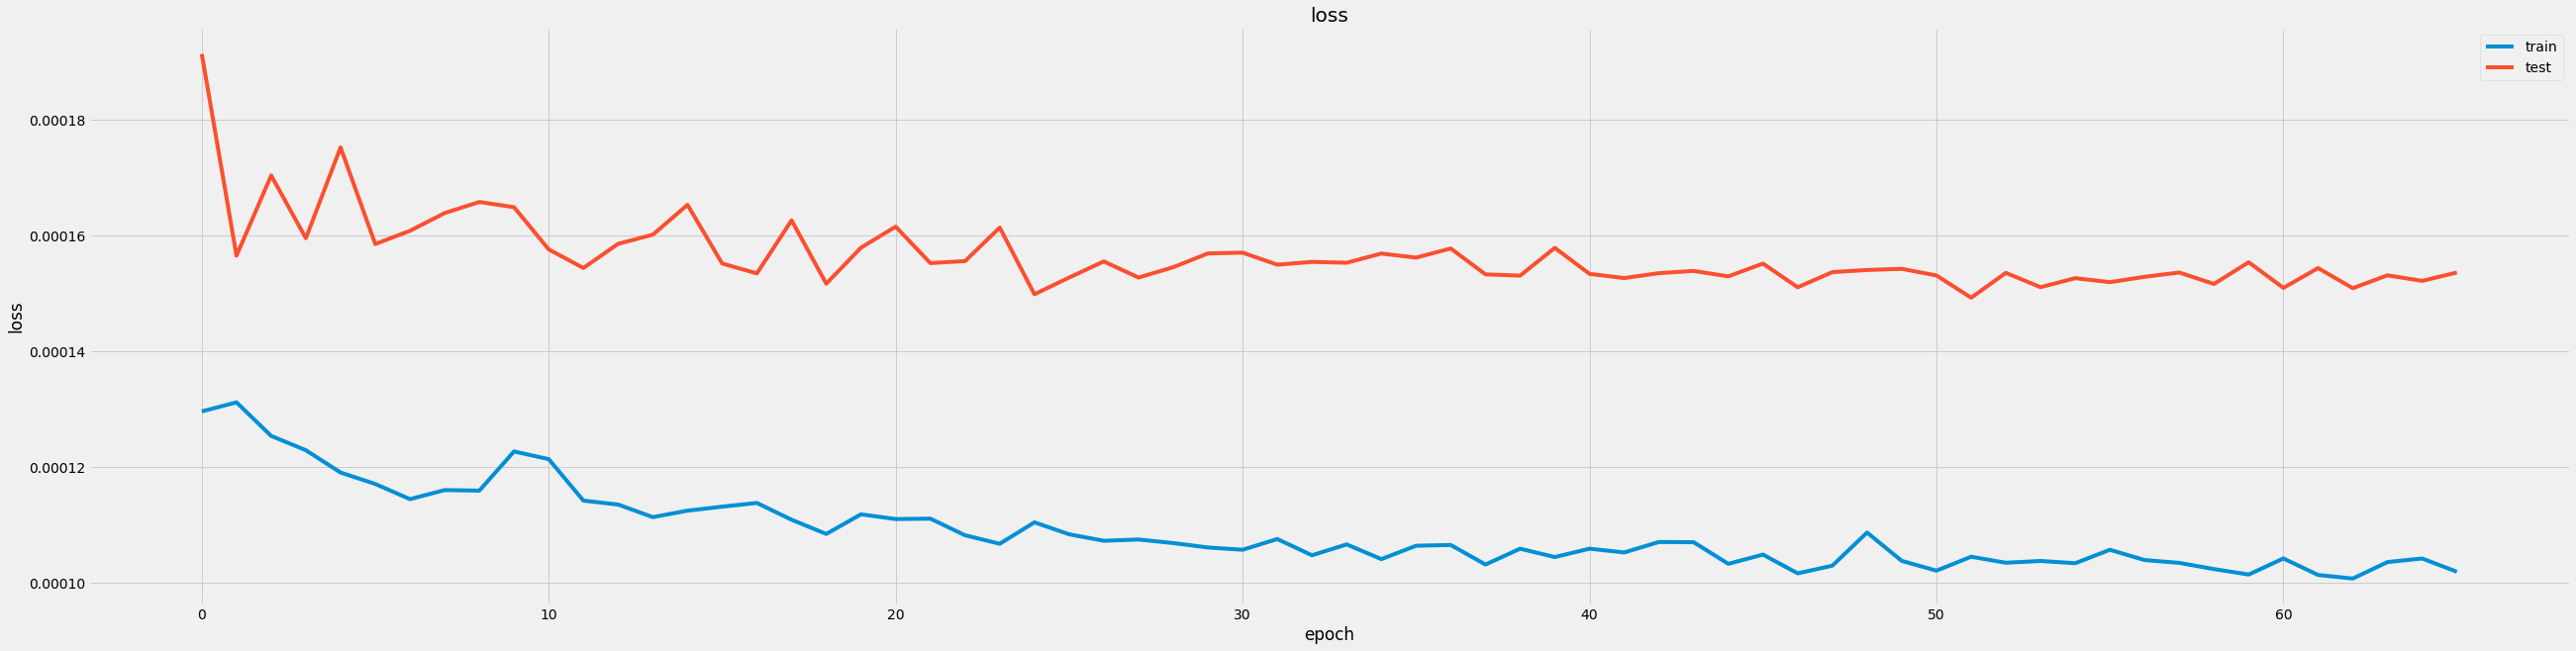

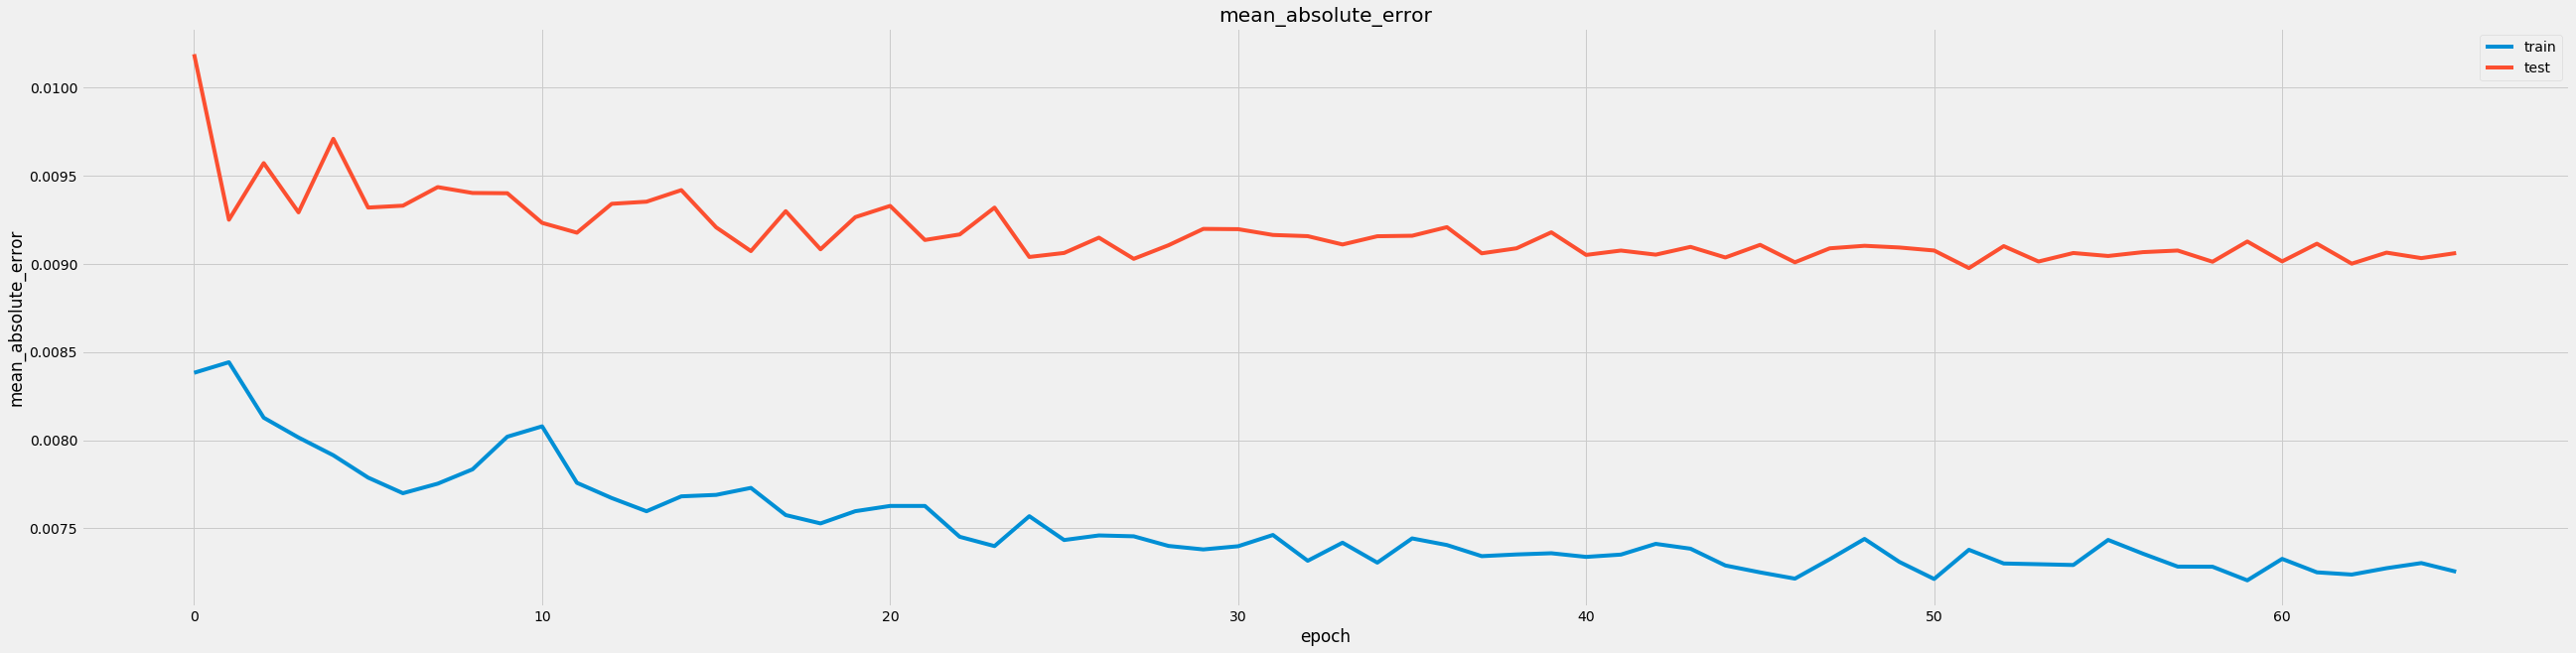

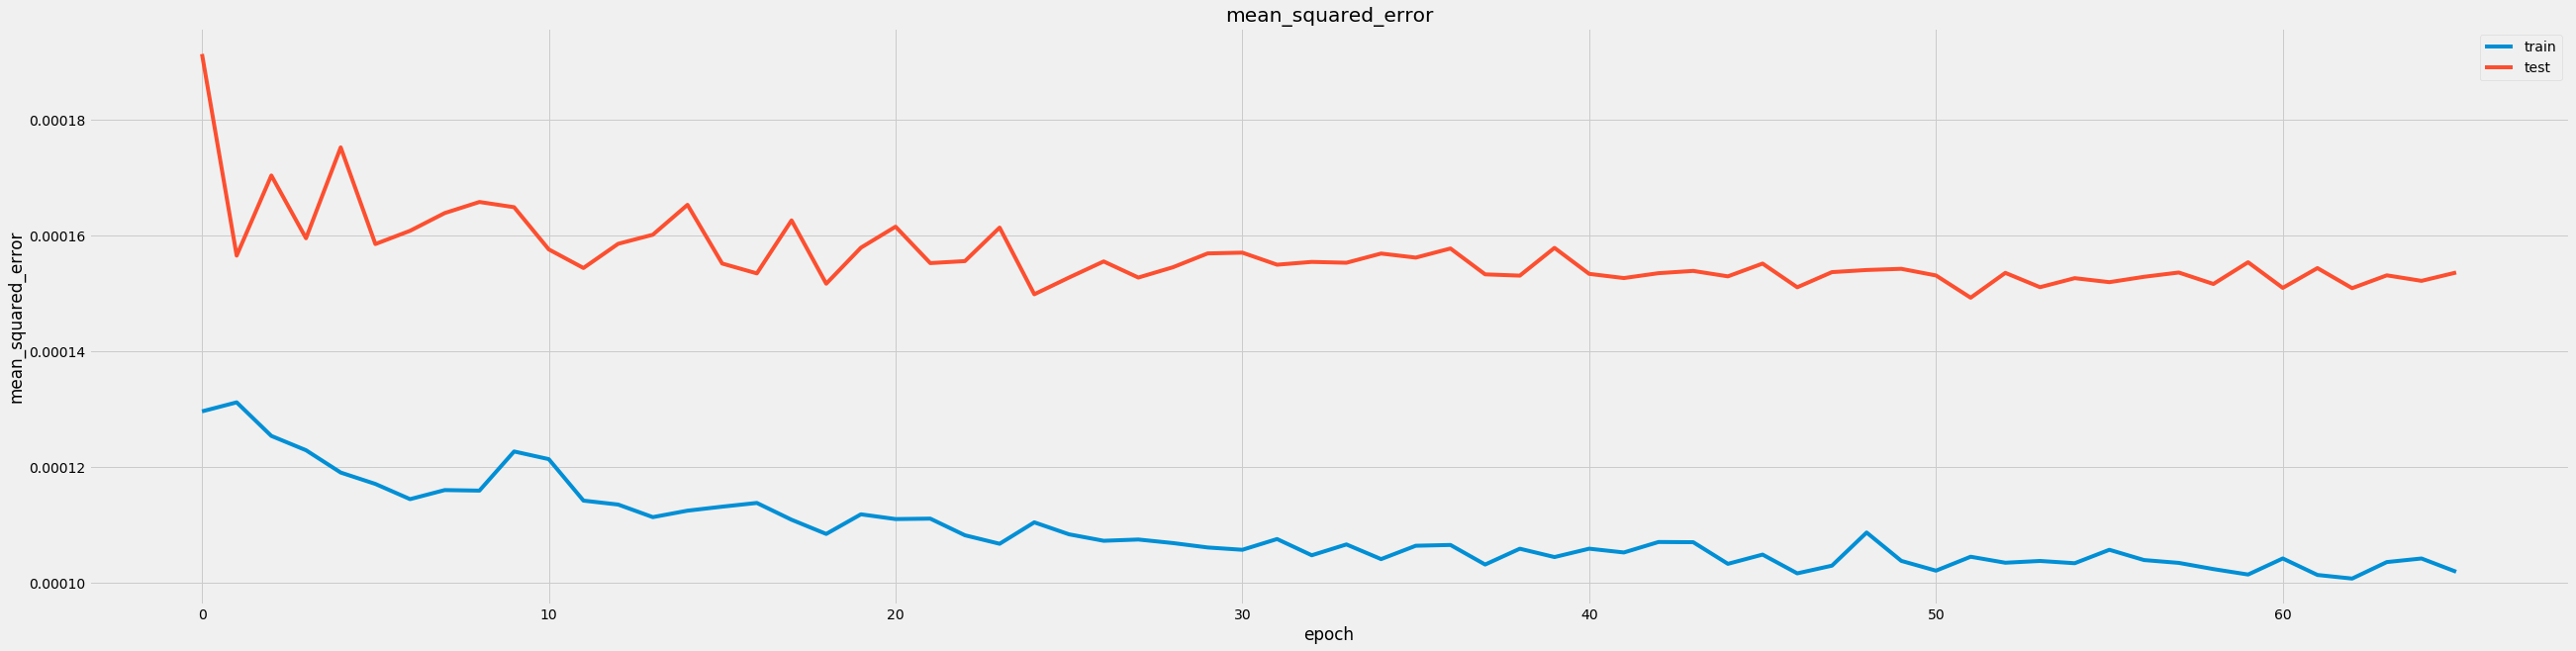

In [36]:
epoch = len(history.history['loss'])
for k in list(history.history.keys()):
    if 'val' not in k:
        if 'lr' not in k:
            plt.figure(figsize=(40,10))
            plt.plot(history.history[k])
            plt.plot(history.history['val_' + k])
            plt.title(k)
            plt.ylabel(k)
            plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper right')
            plt.show()

In [37]:
min(history.history['val_mean_absolute_error'])

0.008976440876722336

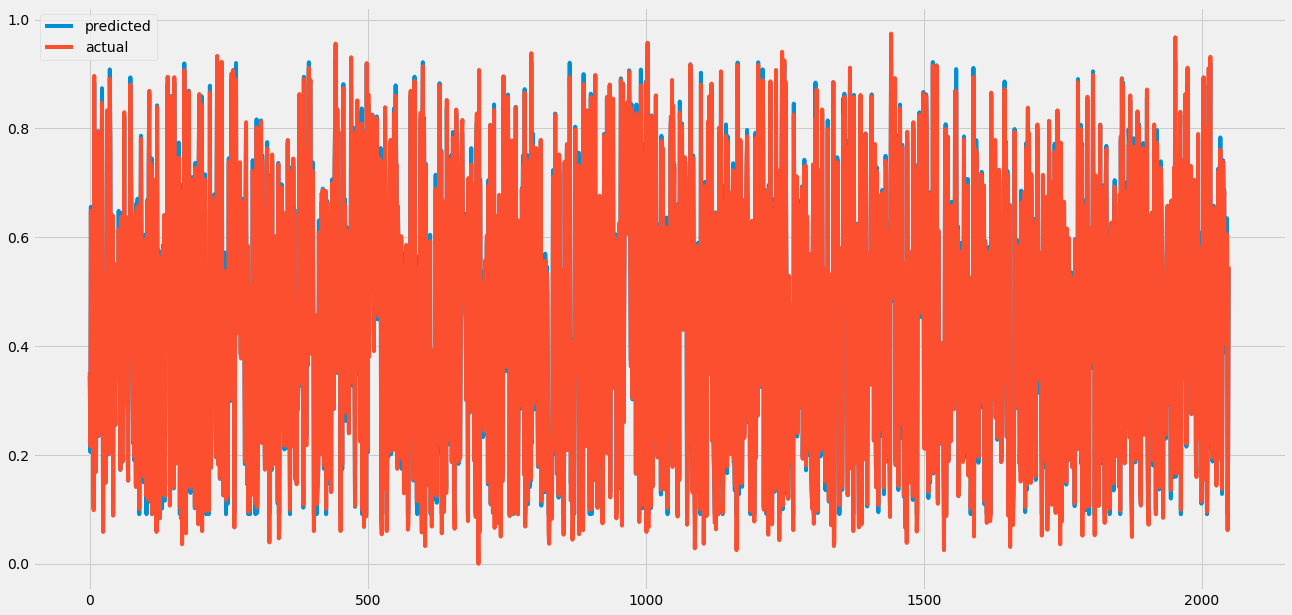

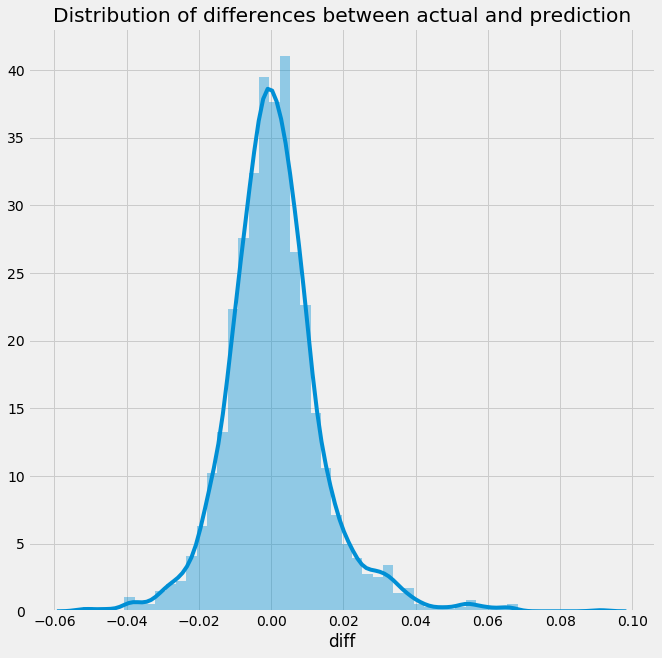

MSE :  0.0001786434335692148
MAE :  0.009505944260159256


count    2049.000000
mean        0.000966
std         0.013334
min        -0.052114
25%        -0.006615
50%         0.000135
75%         0.007447
max         0.091136
Name: diff, dtype: float64

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Benchmark
model.load_weights("weights.best.hdf5")

pred = model.predict(X_test)

predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['actual'] = y_test
predictions = predictions.astype(float)

predictions.plot(figsize=(20,10))
plt.show()

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
sns.distplot(predictions['diff']);
plt.title('Distribution of differences between actual and prediction')
plt.show()

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values))
predictions['diff'].describe()

In [39]:
pred = model.predict(X_test)
pred = y_scaler.inverse_transform(pred)
close = y_scaler.inverse_transform(np.reshape(y_test, (y_test.shape[0], 1)))
predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['close'] = pd.Series(np.reshape(close, (close.shape[0])))

p = df[-pred.shape[0]:].copy()
predictions.index = p.index
predictions = predictions.astype(float)
predictions = predictions.merge(p[['Low', 'High']], right_index=True, left_index=True)

ax = predictions.plot(x=predictions.index, y='close', c='red', figsize=(40,10))
ax = predictions.plot(x=predictions.index, y='predicted', c='blue', figsize=(40,10), ax=ax)
index = [str(item) for item in predictions.index]
plt.fill_between(x=index, y1='Low', y2='High', data=p, alpha=0.4)
plt.title('Prediction vs Actual (low and high as blue region)')
plt.show()

predictions['diff'] = predictions['predicted'] - predictions['close']
plt.figure(figsize=(10,10))
sns.distplot(predictions['diff']);
plt.title('Distribution of differences between actual and prediction ')
plt.show()

g = sns.jointplot("diff", "predicted", data=predictions, kind="kde", space=0)
plt.title('Distributtion of error and price')
plt.show()

# predictions['correct'] = (predictions['predicted'] <= predictions['high']) & (predictions['predicted'] >= predictions['low'])
# sns.factorplot(data=predictions, x='correct', kind='count')

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['close'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['close'].values))
predictions['diff'].describe()

KeyError: "DatetimeIndex(['2001-05-04', '2001-05-03', '2001-05-02', '2001-05-01',\n               '2001-04-30', '2001-04-27', '2001-04-26', '2001-04-25',\n               '2001-04-24', '2001-04-23',\n               ...\n               '1993-06-30', '1993-06-29', '1993-06-28', '1993-06-25',\n               '1993-06-24', '1993-06-23', '1993-06-22', '1993-06-21',\n               '1993-06-18', '1993-06-16'],\n              dtype='datetime64[ns]', name='Date', length=2049, freq=None) not in index"